In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

from K2TranPixCode import *
import lightkurve as lk

In [119]:
save = './test/'
SN2018oh = '../Data/ktwo228682548-c16_lpd-targ.fits.gz'
sn2017k = '../Data/ktwo211545516-c16_lpd-targ.fits.gz'
sn2018p = '../Data/ktwo251502099-c17_lpd-targ.fits.gz'
sn2018ajj = '../Data/ktwo212806553-c17_lpd-targ.fits.gz'
sn2018aji = '../Data/ktwo212827608-c17_lpd-targ.fits.gz'
BS1 = '../Data/ktwo203830112-c112_lpd-targ.fits.gz'

In [120]:
file = sn2018aji
hdu = fits.open(file)
if len(hdu) > 1:
    dat = hdu[1].data
else:
    print('Broken file ', pixelfile)
    
datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data
if datacube.shape[1] > 1 and datacube.shape[2] > 1:
    #datacube = Clip_cube(datacube)

    time = dat["TIME"] + 2454833.0
    Qual = hdu[1].data.field('QUALITY')
    #thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) | (Qual == 1097760) | (Qual == 1048580) | (Qual == 1081348))[0]
    #thrusters = np.insert(thrusters,0,-1)
    #thrusters = np.append(thrusters,len(datacube)-2)
    thrusters = Get_all_resets(datacube,Qual)
    quality = np.where(Qual != 0)[0]

    xdrif = dat['pos_corr1']
    ydrif = dat['pos_corr2']
    distdrif = np.sqrt(xdrif**2 + ydrif**2)
    if len(distdrif) != len(datacube):
        err_string = 'Distance arr is too short for {file}: len = {leng}'.format(file = pixelfile, leng = len(distdrif))
        raise ValueError(err_string) 

    goodthrust = thrusters[np.where(distdrif[thrusters]<0.2)]
    #calculate the reference frame
    if len(goodthrust) > 4:
        Framemin = goodthrust[3]+1
    elif len(goodthrust) > 0:
        Framemin = goodthrust[0]+1
    else:
        Framemin = 100 # Arbitrarily chosen, Data is probably screwed anway if there are no thruster firings.
    # Apply object mask to data
    Mask = ThrustObjectMask(datacube,goodthrust)

    #Maskdata, ast = First_pass(np.copy(datacube),Qual,quality,thrusters,pixelfile)
    Maskdata = np.copy(datacube)
    allMask = np.ones((datacube.shape[1],datacube.shape[2]))
    Maskdata = Correct_motion(datacube, distdrif, thrusters)

In [42]:
lcs = [Maskdata[:,6,5]]
e = 0
x = np.arange(0,len(lcs[e]))
ind = np.isfinite(lcs[e])
fun = interp1d(x[ind],lcs[e][ind],bounds_error = False)
nonan = fun(x)
width = 5*48 - 1

sm = savgol_filter(nonan,width,2,mode='mirror')

<IPython.core.display.Javascript object>


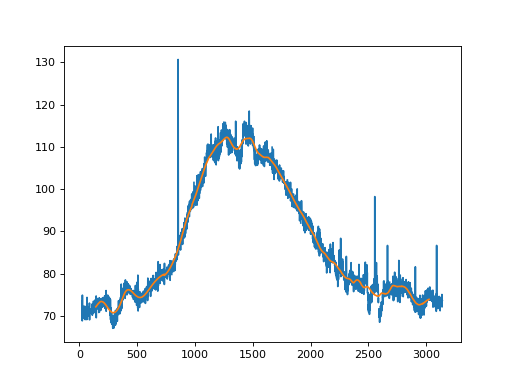

In [43]:
plt.figure()
plt.plot(Maskdata[:,6,5])
plt.plot(sm)

In [65]:
x = np.arange(0,len(Maskdata))
distdrif[distdrif > 10] = np.nan
ind = np.isfinite(distdrif)
fun = interp1d(x[ind],distdrif[ind],bounds_error = False)
nonan = fun(x)
width = 5*48 - 1
sm_dist = savgol_filter(nonan,width,2,mode='nearest')
dist_ind = np.where(sm_dist > 0.4)[0]

X,Y = np.where(np.isfinite(np.nansum(Maskdata,axis=0)))

smoothed = np.zeros_like(Maskdata)
limit = np.zeros_like(Maskdata[0]) * np.nan
for i in range(len(X)):
    lcs = Maskdata[:,X[i],Y[i]]
    lcs[distdrif > .3] = np.nan
    ind = np.isfinite(lcs)
    if len(lcs[ind]) > 10:
        fun = interp1d(x[ind],lcs[ind],bounds_error = False)
        nonan = fun(x)
        width = 5*48 - 1
        sm = savgol_filter(nonan,width,2,mode='nearest')
        smoothed[:,X[i],Y[i]] = sm
        
        pea = find_peaks(sm,distance=4*width)[0]
        maxpeak = pea[np.where(sm[pea] == np.nanmax(sm[pea]))[0]]
        totalmax = np.where(np.nanmax(sm) == sm)[0]
        #if (X[i] == 14) & (Y[i] == 0):
        #    break

        ind = np.arange(0,len(smoothed))
        m_s = ind < int(maxpeak-2*width)
        m_e = ind > int(maxpeak+4*width)
        mean_start = np.nanmean(sm[m_s]) 
        mean_end   = np.nanmean(sm[m_e]) 

        std_start = np.nanstd(sm[m_s])
        std_end = np.nanstd(sm[m_e])
        if (maxpeak not in dist_ind) & (totalmax not in dist_ind):
            #print(X[i],Y[i], maxpeak)
            if np.isfinite(mean_start) & np.isfinite(mean_end):
                if mean_end > (mean_start + 3*std_start):
                    print('start only')
                    mean_outside = mean_start
                    std_outside = std_start
                else:
                    mean_outside = np.nanmean(sm[m_s+m_e])
                    std_outside = np.nanstd(sm[m_s+m_e])
            else:
                mean_outside = np.nanmean(sm[m_s+m_e])
                std_outside = np.nanstd(sm[m_s+m_e])
            limit[X[i],Y[i]] = mean_outside +3*std_outside
        else:
            limit[X[i],Y[i]] = np.nan#sm[maxpeak]
    else:
        smoothed[:,X[i],Y[i]] = np.nan
        

start only
start only
start only
start only
start only
start only
start only


<IPython.core.display.Javascript object>


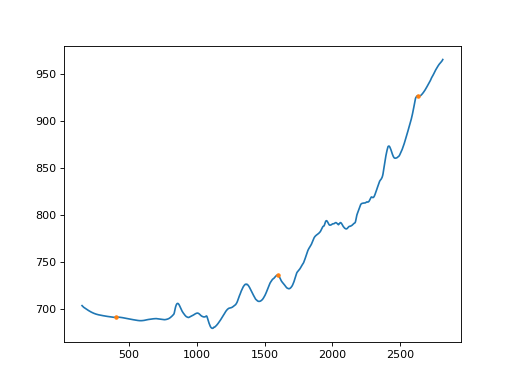

In [50]:
plt.figure()
plt.plot(sm)
plt.plot(pea,sm[pea],'.')

In [51]:
maxpeak = pea[np.where(sm[pea] == np.nanmax(sm[pea]))[0]]

In [53]:
sm.shape

(3283,)

In [54]:
datacube.shape

(3283, 16, 16)

In [98]:
def Long_smooth_limit(Data,Dist):
    x = np.arange(0,len(Data))
    Dist[Dist > 10] = np.nan
    ind = np.isfinite(Dist)
    fun = interp1d(x[ind],Dist[ind],bounds_error = False)
    nonan = fun(x)
    width = 5*48 - 1
    sm_dist = savgol_filter(nonan,width,2,mode='nearest')
    dist_ind = np.where(sm_dist > 0.4)[0]

    X,Y = np.where(np.isfinite(np.nansum(Data,axis=0)))

    smoothed = np.zeros_like(Data)
    limit = np.zeros_like(Data[0]) * np.nan
    for i in range(len(X)):
        lcs = Data[:,X[i],Y[i]]
        lcs[Dist > .3] = np.nan
        ind = np.isfinite(lcs)
        if len(lcs[ind]) > 10:
            fun = interp1d(x[ind],lcs[ind],bounds_error = False)
            nonan = fun(x)
            width = 5*48 - 1
            sm = savgol_filter(nonan,width,2,mode='nearest')
            smoothed[:,X[i],Y[i]] = sm

            pea = find_peaks(sm,distance=4*width)[0]
            maxpeak = pea[np.where(sm[pea] == np.nanmax(sm[pea]))[0]]
            totalmax = np.where(np.nanmax(sm) == sm)[0]
            
            ind = np.arange(0,len(smoothed))
            m_s = ind < int(maxpeak-2*width)
            m_e = ind > int(maxpeak+4*width)
            mean_start = np.nanmean(sm[m_s]) 
            mean_end   = np.nanmean(sm[m_e]) 

            std_start = np.nanstd(sm[m_s])
            std_end = np.nanstd(sm[m_e])
            if (maxpeak not in dist_ind) & (totalmax not in dist_ind):
                if np.isfinite(mean_start) & np.isfinite(mean_end):
                    if mean_end > (mean_start + 3*std_start):
                        print('start only')
                        mean_outside = mean_start
                        std_outside = std_start
                    else:
                        mean_outside = np.nanmean(sm[m_s+m_e])
                        std_outside = np.nanstd(sm[m_s+m_e])
                else:
                    mean_outside = np.nanmean(sm[m_s+m_e])
                    std_outside = np.nanstd(sm[m_s+m_e])
                limit[X[i],Y[i]] = mean_outside +3*std_outside
            else:
                limit[X[i],Y[i]] = np.nan#sm[maxpeak]
        else:
            smoothed[:,X[i],Y[i]] = np.nan
    limit[limit<22] = 22
    return smoothed, limit

def Vet_long(Events, Eventtime, Eventmask, Data):
    good_ind = []
    for i in range(len(Events)):
        eh = Data[Eventtime[i,0]:Eventtime[i,1],Eventmask[i][0],Eventmask[i][1]]
        r2 = Regress_fit(eh, Fit = False)
        
        
        if r2 > 0.85:
            good_ind += [i]
    good_ind = np.array(good_ind)
    
    if len(good_ind) > 0:
        Events = Events[good_ind]
        Eventtime = Eventtime[good_ind]
        Eventmask = np.array(Eventmask)[good_ind].tolist()
    else:
        Events = np.array([])
        Eventtime = np.array([])
        Eventmask = []
    return Events, Eventtime, Eventmask
        

def Show_events(eventtime,eventmask,Data,raw):
    for i in range(len(eventtime)):
        lc = Lightcurve(Data,eventmask[i])
        #lc[lc == 0] = np.nan
        plt.figure()
        plt.axvspan(eventtime[i,0],eventtime[i,1],color='orange')
        #plt.plot(Lightcurve(raw,eventmask[i]))
        plt.plot(lc,'.')
        
        

In [ ]:
def Find_long(Data, Dist):
    smoothed, limit = Long_smooth_limit(Maskdata.copy(),distdrif.copy())
    framemask = (smoothed/limit)
    events = []
    eventtime = []
    eventmask = []
    events, eventtime, eventmask = Event_ID(framemask, 1, 10*48,Smoothing=False)
    events, eventtime, eventmask = Vet_long(events, eventtime, eventmask, framemask)
    events, eventtime, eventmask = Match_events(events,eventtime,eventmask,Maskdata.copy())
    

start only
start only
2
1


<IPython.core.display.Javascript object>


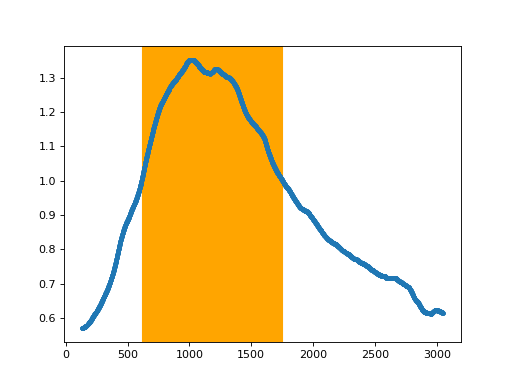

In [121]:
smoothed, limit = Long_smooth_limit(Maskdata.copy(),distdrif.copy())

framemask = (smoothed/limit)


events = []
eventtime = []
eventmask = []
events, eventtime, eventmask = Event_ID(framemask, 1, 10*48,Smoothing=False)
print(len(events))
events, eventtime, eventmask = Vet_long(events, eventtime, eventmask, framemask)
print(len(events))
events, eventtime, eventmask = Match_events(events,eventtime,eventmask,Maskdata.copy())

events

Show_events(eventtime,eventmask,framemask,datacube)

<IPython.core.display.Javascript object>


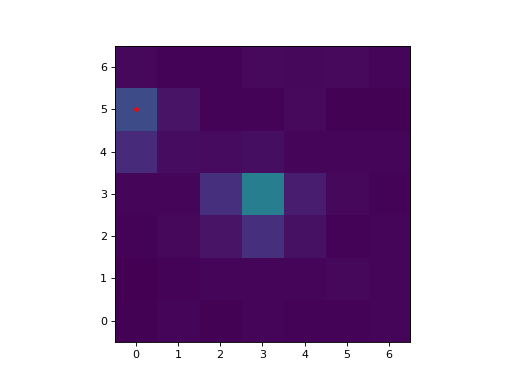

In [122]:
plt.figure()
plt.imshow(datacube[1600],origin='lower',vmax=500)
for e in eventmask:
    plt.plot(e[1],e[0],'r.')



<IPython.core.display.Javascript object>


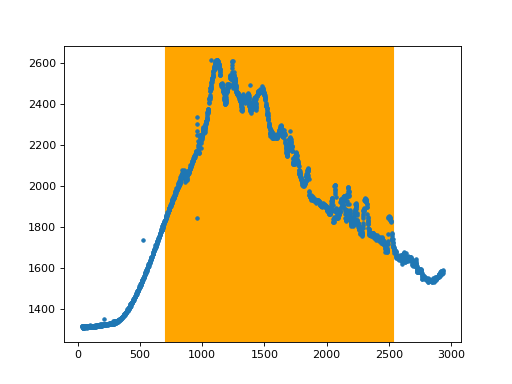

In [113]:
Show_events(eventtime,eventmask,Maskdata,datacube)

In [141]:
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.optimize import curve_fit
import scipy.special as sp

from sklearn.metrics import mean_squared_error, r2_score

In [123]:
def func(x, sigmag, mu, alpha, c,a):
    #normal distribution
    normpdf = (1/(sigmag*np.sqrt(2*np.pi)))*np.exp(-(np.power((x-mu),2)/(2*np.power(sigmag,2))))
    normcdf = (0.5*(1+sp.erf((alpha*((x-mu)/sigmag))/(np.sqrt(2)))))
    return 2*a*normpdf*normcdf + c

In [85]:
Dist = distdrif
x = np.arange(0,len(datacube))
Dist[Dist > 10] = np.nan
ind = np.isfinite(Dist)
fun = interp1d(x[ind],Dist[ind],bounds_error = False)
nonan = fun(x)
width = 5*48 - 1
sm_dist = savgol_filter(nonan,width,2,mode='nearest')
dist_ind = np.where(sm_dist > 0.4)[0]

<IPython.core.display.Javascript object>


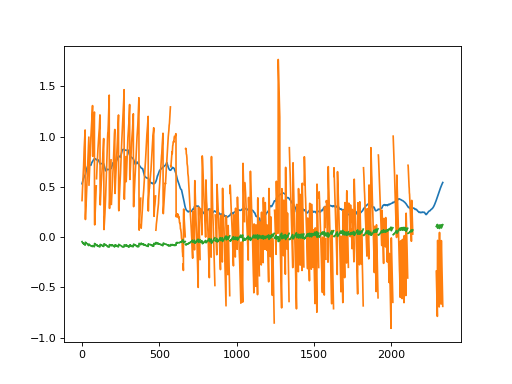

In [90]:
distdrif[distdrif > 10] = np.nan
xdrif[abs(xdrif) > 10] = np.nan
ydrif[abs(ydrif) > 10] = np.nan
plt.figure()
plt.plot(sm_dist)
plt.plot(xdrif)
plt.plot(ydrif)

In [15]:
len(eh)

1076

In [123]:
i = 0
eh = Lightcurve(framemask[eventtime[i,0]:eventtime[i,1]],eventmask[i])
xx = np.arange(0,len(eh))


Data = eh.copy()
y = eh.copy()
x = xx.copy()
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features = PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

r2 = r2_score(y,y_poly_pred)

sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)

mod = np.zeros_like(Data)
xx = np.zeros_like(Data)
for i in range(len(mod)):
    mod[i] = y_poly_pred[i][0]
    xx[i] = x[i][0]
temp = interp1d(xx,mod,bounds_error = False,fill_value='extrapolate')
mod = temp(np.arange(0,len(Data)))

if r2 > 0.9:
    print('good!')
else:
    print('BAD')

good!


0.9888676322068054


<IPython.core.display.Javascript object>


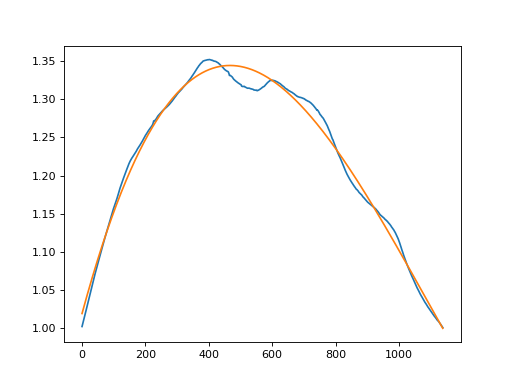

In [124]:
print(r2)
plt.figure()
plt.plot(xx,eh)
plt.plot(mod)


<IPython.core.display.Javascript object>


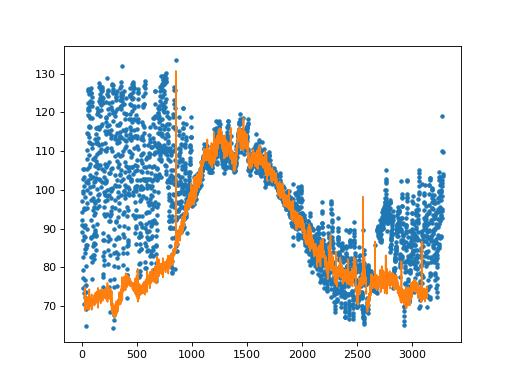

In [186]:
plt.figure()
plt.plot(datacube[:,6,5],'.')
plt.plot(Maskdata[:,6,5])

#for t in thrusters:
#    plt.axvline(t,color='k')

<IPython.core.display.Javascript object>


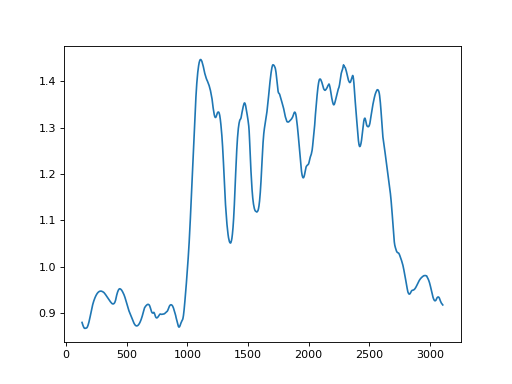

In [308]:
plt.figure()
plt.plot(framemask[:,3,5])

In [22]:
Median_clip(datacube[308:320,6,5])

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
sigma_clip()

In [5]:
t1 = np.where((Qual == 1048576) | (Qual == 1089568) | \
            (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | \
            (Qual == 10240) | (Qual == 32768) | (Qual == 1097760) | \
            (Qual == 1048580) | (Qual == 1081348))[0]
t1 = np.insert(t1,0,-1)
t1 = np.append(t1,len(datacube)-2)

c1 = Correct_motion(datacube, distdrif, t1)



In [6]:
t2 = Get_all_resets(datacube, Qual)
c2 = Correct_motion(datacube, distdrif, t2)

In [9]:
X,Y = np.where(np.isfinite(np.nansum(c1,axis=0)))
x = np.arange(0,len(c1))
s1 = np.zeros_like(c1)
for i in range(len(X)):
    lcs = c1[:,X[i],Y[i]]
    ind = np.isfinite(lcs)
    if len(lcs[ind]) > 10:
        fun = interp1d(x[ind],lcs[ind],bounds_error = False)
        nonan = fun(x)
        width = 10*48 - 1
        sm = savgol_filter(nonan,width,2,mode='nearest')
        s1[:,X[i],Y[i]] = sm
    else:
        s1[:,X[i],Y[i]] = np.nan
        
X,Y = np.where(np.isfinite(np.nansum(c2,axis=0)))
x = np.arange(0,len(c2))
s2 = np.zeros_like(c2)
for i in range(len(X)):
    lcs = c2[:,X[i],Y[i]]
    ind = np.isfinite(lcs)
    if len(lcs[ind]) > 10:
        fun = interp1d(x[ind],lcs[ind],bounds_error = False)
        nonan = fun(x)
        width = 10*48 - 1
        sm = savgol_filter(nonan,width,2,mode='nearest')
        s2[:,X[i],Y[i]] = sm
    else:
        s2[:,X[i],Y[i]] = np.nan